In [2]:
import matplotlib
import matplotlib.pyplot as plt
import torch
import numpy as np
import scipy.io as sio

from data import Darcys_Dataset
from unet2d_spatial import Unet2D_Spatial
from diffuser import GaussianDiffusion

In [2]:
ds = Darcys_Dataset('../data/darcy_data_r241_N200.mat')

Loaded 200 samples from ../data/darcy_data_r241_N200.mat
Shape of x: torch.Size([200, 1, 240, 240])


In [4]:
ds.a.shape

torch.Size([200, 1, 240, 240])

In [5]:
ds.u.shape

torch.Size([200, 1, 240, 240])

### Visualization of Data

In [3]:
def unnormalize(x, x_max=12, x_min=3):
    x_clip = np.clip(x, 0, 1)
    # set the entry greater than 0.5 to be x_max, and less than 0.5 to be x_min
    x_clip[x_clip > 0.5] = x_max
    x_clip[x_clip <= 0.5] = x_min
    return x_clip

In [4]:
x_range = torch.linspace(0, 1, 241)[:-1]
y_range = torch.linspace(0, 1, 241)[:-1]
X, Y = torch.meshgrid(x_range, y_range, indexing='ij')

In [32]:
a = ds.a[160:165].squeeze()
u = ds.u[160:165].squeeze()

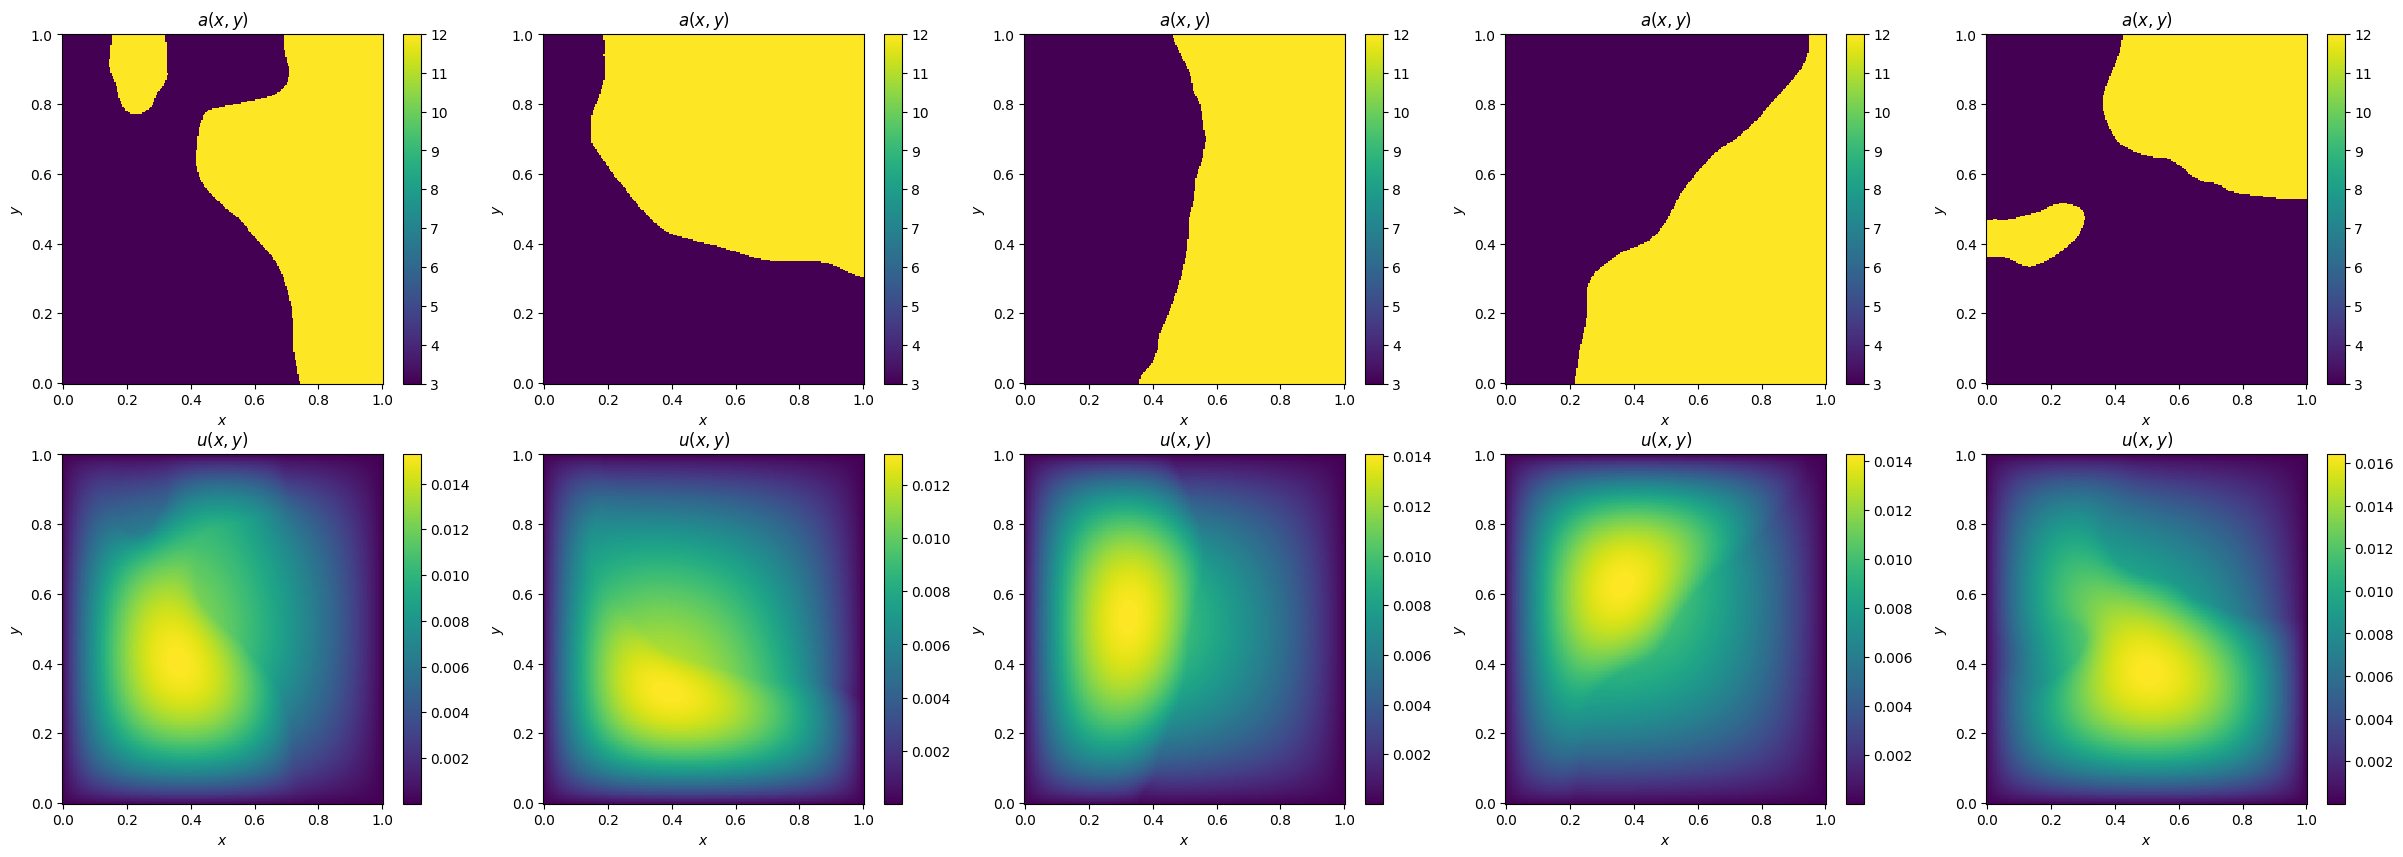

In [33]:
fig, ax = plt.subplots(2, 5, figsize=(30, 10))
for i in range(5):
    im1 = ax[0, i].pcolormesh(X, Y, unnormalize(a[i]))
    ax[0, i].set_xlabel('$x$')
    ax[0, i].set_ylabel('$y$')
    ax[0, i].set_title('$a(x, y)$')
    fig.colorbar(im1, ax=ax[0, i])

    im2 = ax[1, i].pcolormesh(X, Y, u[i])
    ax[1, i].set_xlabel('$x$')
    ax[1, i].set_ylabel('$y$')
    ax[1, i].set_title('$u(x, y)$')
    fig.colorbar(im2, ax=ax[1, i])

In [34]:
fig.savefig('../assets/darcy/darcy_visualization.png', dpi=300, bbox_inches='tight')

### Model Test

In [5]:
model = Unet2D_Spatial(
    channels=1,
    cond_channels=1,
    channel_mults=(1, 2, 4, 8),
    init_conv_channels=32,
    init_conv_kernel_size=5
)
diffusion_model = GaussianDiffusion(
    model=model,
    sample_size=(1, 240, 240),
    timesteps=800,
    objective='pred_x0',
    physics_loss_weight=0.0
).to("cuda:0")

In [9]:
x = ds[30:38]['x']
y = ds[30:38]['y']

In [10]:
def make_prediction(diffusion_model, cond, physics_loss_weight):
    weights = torch.load(f"../ckpts/ddpm/darcy_{physics_loss_weight:.2f}phyloss/ckpt_clean.pt", map_location={'cuda:1':'cuda:0'})
    diffusion_model.model.load_state_dict(weights)
    x_pred = diffusion_model.sample(cond=cond)

    return x_pred.cpu().numpy().squeeze()

In [11]:
x_pred000 = make_prediction(diffusion_model, y, 0.00)


DDPM sampling: 100%|██████████| 800/800 [01:41<00:00,  7.88it/s]


In [9]:
x_span = np.linspace(0, 1, 240)
y_span = np.linspace(0, 1, 240)
X, Y = np.meshgrid(x_span, y_span)

In [10]:
x = x.numpy().squeeze()
y = y.numpy().squeeze()

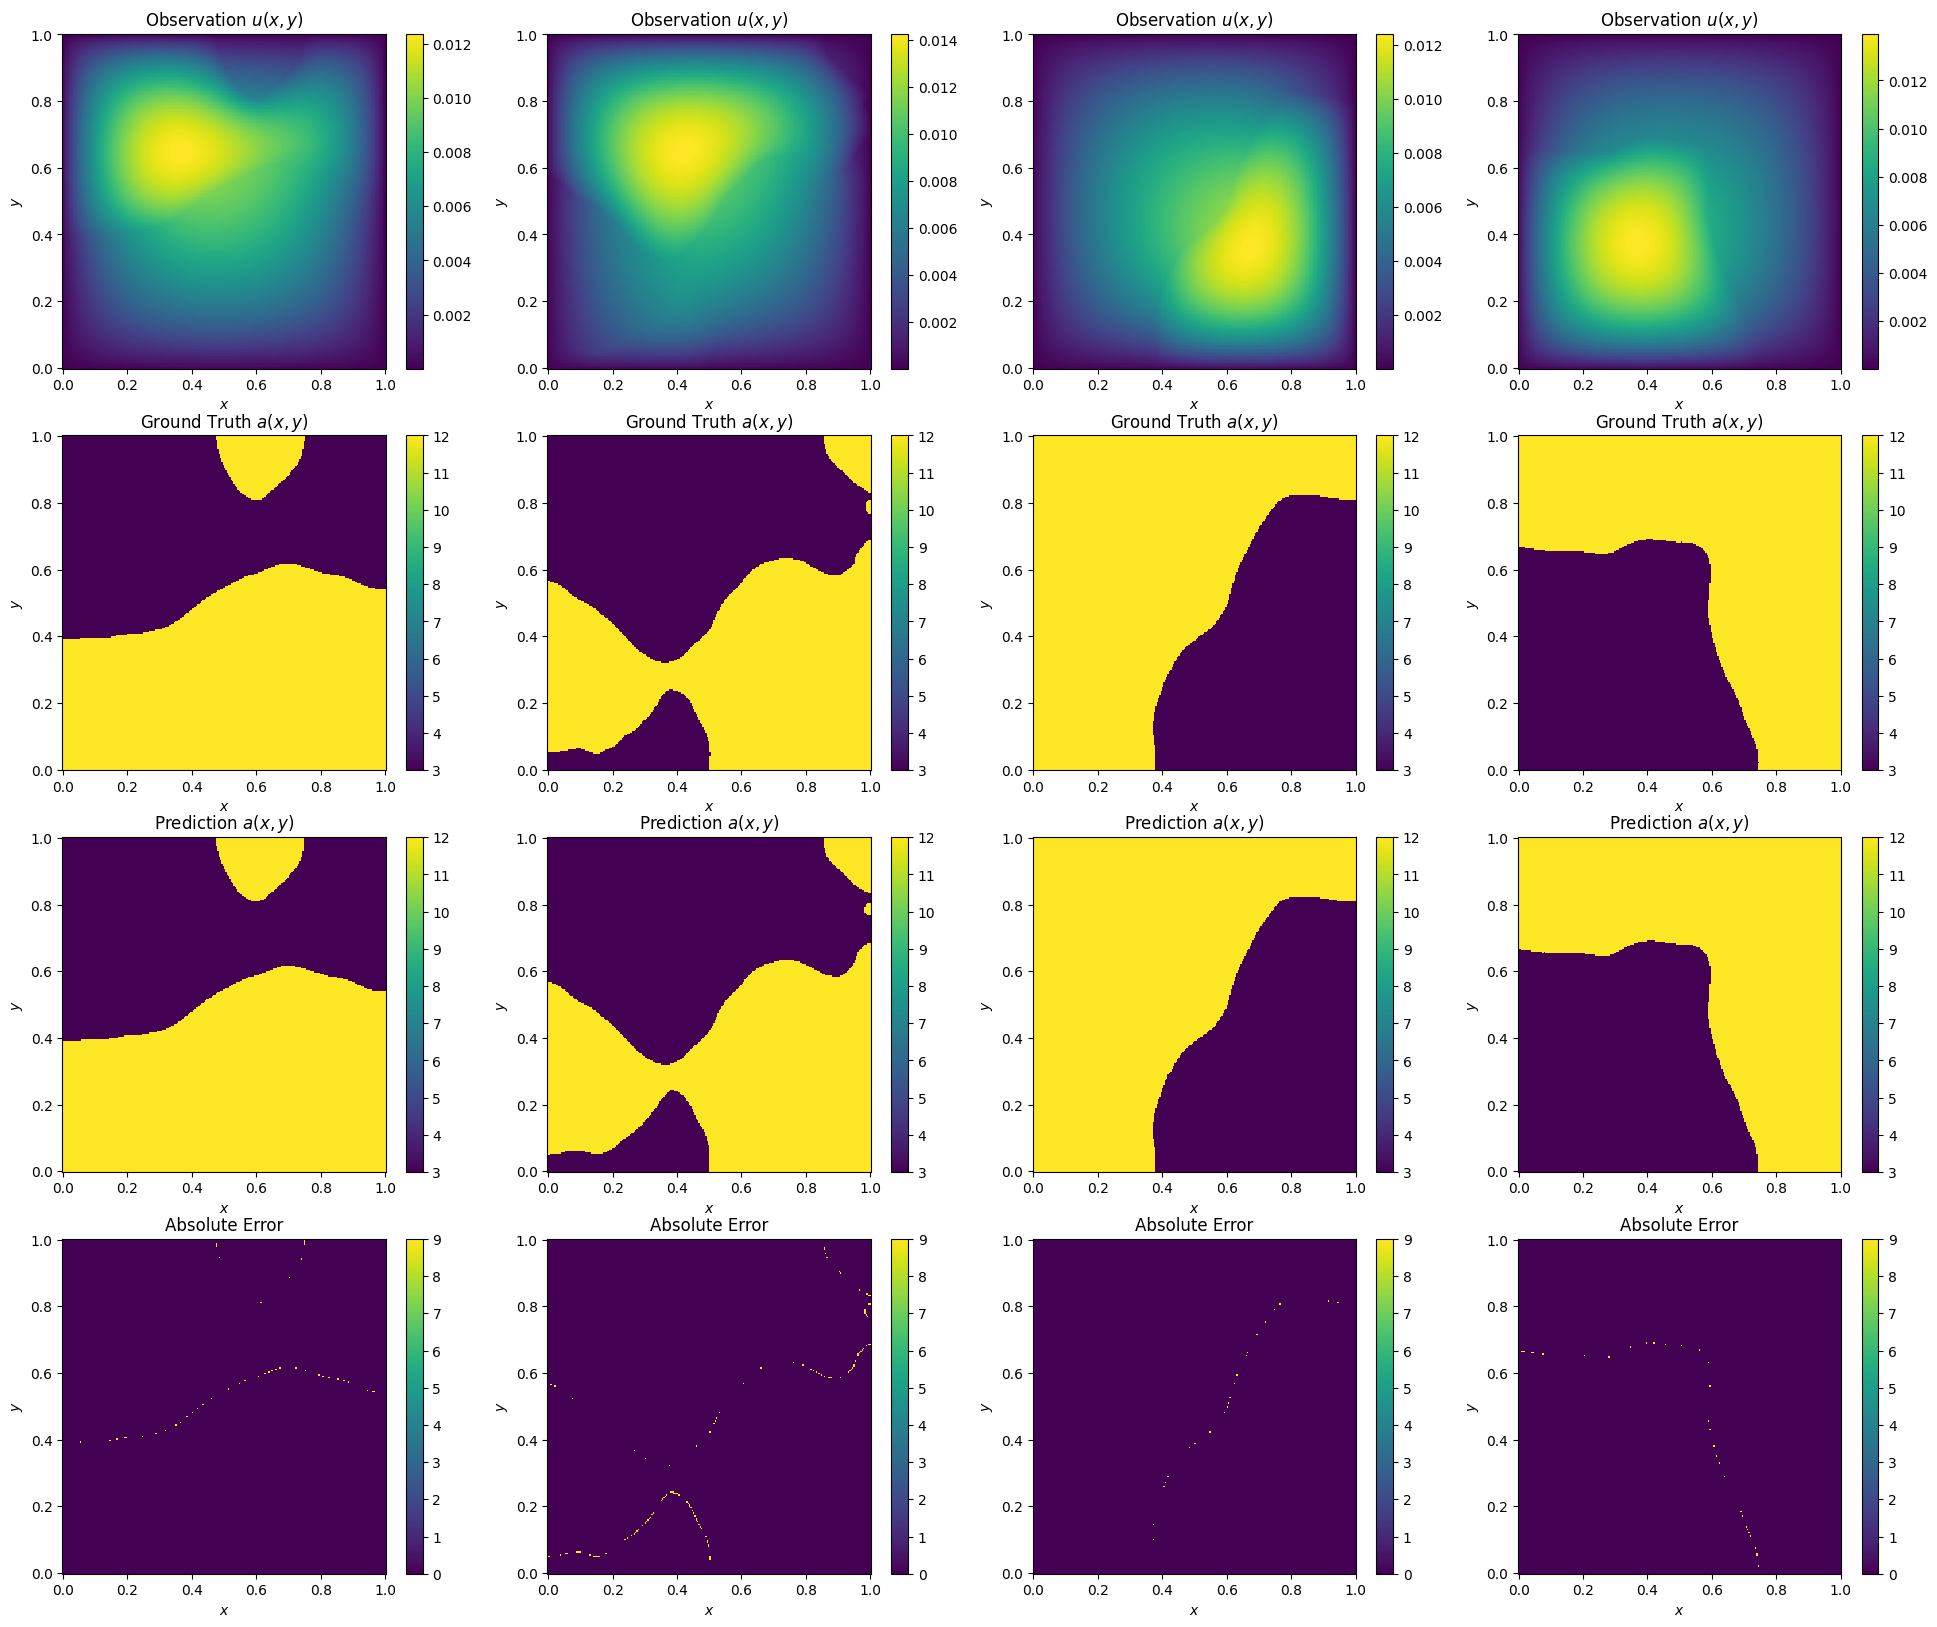

In [11]:
fig, ax = plt.subplots(4, 4, figsize=(24, 20))
for i in range(4):
    im1 = ax[0, i].pcolormesh(X, Y, y[i])
    ax[0, i].set_xlabel('$x$')
    ax[0, i].set_ylabel('$y$')
    ax[0, i].set_title('Observation $u(x, y)$')
    fig.colorbar(im1, ax=ax[0, i])

    im2 = ax[1, i].pcolormesh(X, Y, unnormalize(x[i]))
    ax[1, i].set_xlabel('$x$')
    ax[1, i].set_ylabel('$y$')
    ax[1, i].set_title('Ground Truth $a(x, y)$')
    fig.colorbar(im2, ax=ax[1, i])

    im3 = ax[2, i].pcolormesh(X, Y, unnormalize(x_pred000[i]))
    ax[2, i].set_xlabel('$x$')
    ax[2, i].set_ylabel('$y$')
    ax[2, i].set_title('Prediction $a(x, y)$')
    fig.colorbar(im3, ax=ax[2, i])

    im4 = ax[3, i].pcolormesh(X, Y, np.abs(unnormalize(x_pred000[i])-unnormalize(x[i])))
    ax[3, i].set_xlabel('$x$')
    ax[3, i].set_ylabel('$y$')
    ax[3, i].set_title('Absolute Error')
    fig.colorbar(im4, ax=ax[3, i])

In [12]:
fig.savefig('../assets/darcy/darcy_prediction.png', dpi=300, bbox_inches='tight')

### Parameters comparison

In [12]:
x_pred005 = make_prediction(diffusion_model, y, 0.05)
x_pred010 = make_prediction(diffusion_model, y, 0.10)
x_pred020 = make_prediction(diffusion_model, y, 0.20)

DDPM sampling: 100%|██████████| 800/800 [01:40<00:00,  7.96it/s]


In [20]:
x = x.numpy().squeeze()
y = y.numpy().squeeze()

In [32]:
def cal_mis_classification_rate(x, x_pred, x_max=12, x_min=3):
    b_size = x.shape[0]
    x = unnormalize(x, x_max, x_min)
    x_pred = unnormalize(x_pred, x_max, x_min)
    rate = np.sum(np.abs(x-x_pred) > 0.0, axis=(1, 2)) / (240*240)
    mean = np.mean(rate, axis=0)
    std = np.std(rate, axis=0)
    return {'mean': mean, 'std': std}

In [34]:
x = x.numpy().squeeze()

In [35]:
mcr000 = cal_mis_classification_rate(x, x_pred000)
mcr005 = cal_mis_classification_rate(x, x_pred005)
mcr010 = cal_mis_classification_rate(x, x_pred010)
mcr020 = cal_mis_classification_rate(x, x_pred020)

In [38]:
print(f"Accuracy rate for 0.00 physics loss: {1-mcr000['mean']:.3%} ± {mcr000['std']:.3%}")
print(f"Accuracy rate for 0.05 physics loss: {1-mcr005['mean']:.3%} ± {mcr005['std']:.3%}")
print(f"Accuracy rate for 0.10 physics loss: {1-mcr010['mean']:.3%} ± {mcr010['std']:.3%}")
print(f"Accuracy rate for 0.20 physics loss: {1-mcr020['mean']:.3%} ± {mcr020['std']:.3%}")

Accuracy rate for 0.00 physics loss: 99.936% ± 0.056%
Accuracy rate for 0.05 physics loss: 99.930% ± 0.061%
Accuracy rate for 0.10 physics loss: 99.891% ± 0.096%
Accuracy rate for 0.20 physics loss: 99.874% ± 0.098%


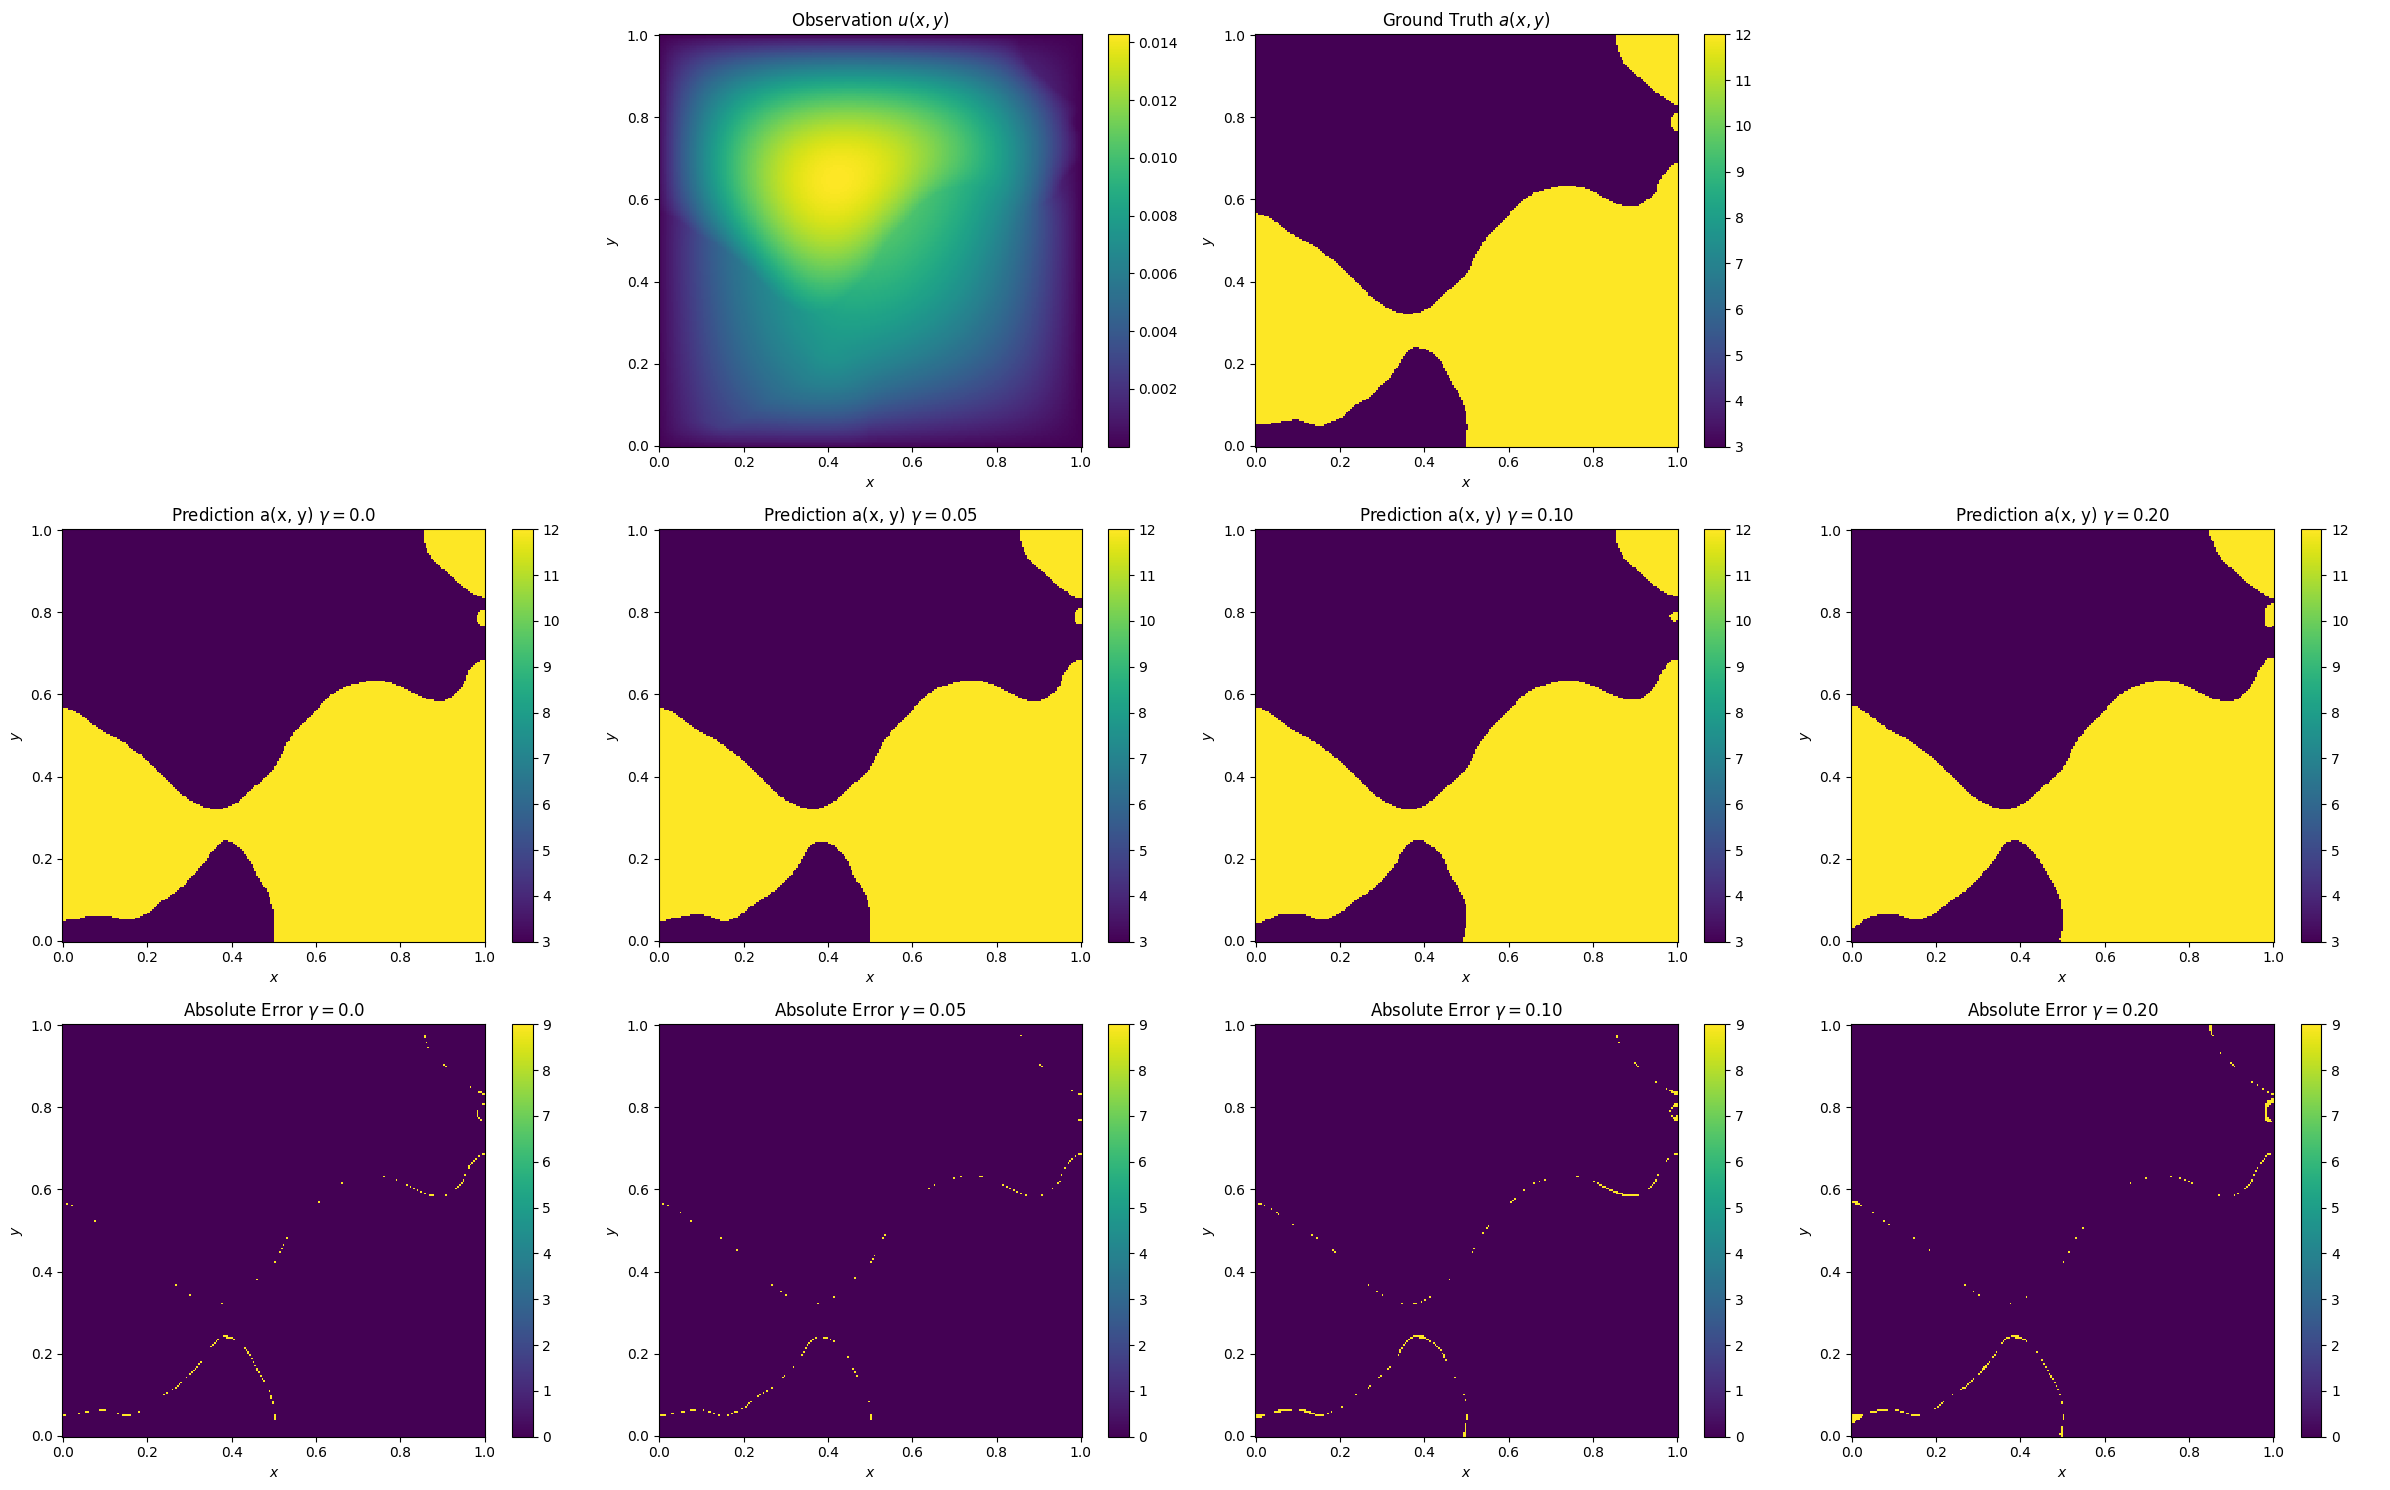

In [30]:
n = 1
fig, ax = plt.subplots(3, 4, figsize=(24, 15))
ax[0, 0].set_axis_off()
ax[0, 3].set_axis_off()

im1 = ax[0, 1].pcolormesh(X, Y, y[n])
ax[0, 1].set_xlabel('$x$')
ax[0, 1].set_ylabel('$y$')
ax[0, 1].set_title('Observation $u(x, y)$')
fig.colorbar(im1, ax=ax[0, 1])
plt.tight_layout()

im2 = ax[0, 2].pcolormesh(X, Y, unnormalize(x[n]))
ax[0, 2].set_xlabel('$x$')
ax[0, 2].set_ylabel('$y$')
ax[0, 2].set_title('Ground Truth $a(x, y)$')
fig.colorbar(im2, ax=ax[0, 2])
plt.tight_layout()

im3 = ax[1, 0].pcolormesh(X, Y, unnormalize(x_pred000[n]))
ax[1, 0].set_xlabel('$x$')
ax[1, 0].set_ylabel('$y$')
ax[1, 0].set_title(r'Prediction a(x, y) $\gamma=0.0$')
fig.colorbar(im3, ax=ax[1, 0])
plt.tight_layout()

im4 = ax[1, 1].pcolormesh(X, Y, unnormalize(x_pred005[n]))
ax[1, 1].set_xlabel('$x$')
ax[1, 1].set_ylabel('$y$')
ax[1, 1].set_title(r'Prediction a(x, y) $\gamma=0.05$')
fig.colorbar(im4, ax=ax[1, 1])
plt.tight_layout()

im5 = ax[1, 2].pcolormesh(X, Y, unnormalize(x_pred010[n]))
ax[1, 2].set_xlabel('$x$')
ax[1, 2].set_ylabel('$y$')
ax[1, 2].set_title(r'Prediction a(x, y) $\gamma=0.10$')
fig.colorbar(im5, ax=ax[1, 2])
plt.tight_layout()

im6 = ax[1, 3].pcolormesh(X, Y, unnormalize(x_pred020[n]))
ax[1, 3].set_xlabel('$x$')
ax[1, 3].set_ylabel('$y$')
ax[1, 3].set_title(r'Prediction a(x, y) $\gamma=0.20$')
fig.colorbar(im6, ax=ax[1, 3])
plt.tight_layout()

im7 = ax[2, 0].pcolormesh(X, Y, np.abs(unnormalize(x_pred000[n])-unnormalize(x[n])))
ax[2, 0].set_xlabel('$x$')
ax[2, 0].set_ylabel('$y$')
ax[2, 0].set_title(r'Absolute Error $\gamma=0.0$')
fig.colorbar(im7, ax=ax[2, 0])
plt.tight_layout()

im8 = ax[2, 1].pcolormesh(X, Y, np.abs(unnormalize(x_pred005[n])-unnormalize(x[n])))
ax[2, 1].set_xlabel('$x$')
ax[2, 1].set_ylabel('$y$')
ax[2, 1].set_title(r'Absolute Error $\gamma=0.05$')
fig.colorbar(im8, ax=ax[2, 1])
plt.tight_layout()

im9 = ax[2, 2].pcolormesh(X, Y, np.abs(unnormalize(x_pred010[n])-unnormalize(x[n])))
ax[2, 2].set_xlabel('$x$')
ax[2, 2].set_ylabel('$y$')
ax[2, 2].set_title(r'Absolute Error $\gamma=0.10$')
fig.colorbar(im9, ax=ax[2, 2])
plt.tight_layout()

im10 = ax[2, 3].pcolormesh(X, Y, np.abs(unnormalize(x_pred020[n])-unnormalize(x[n])))
ax[2, 3].set_xlabel('$x$')
ax[2, 3].set_ylabel('$y$')
ax[2, 3].set_title(r'Absolute Error $\gamma=0.20$')
fig.colorbar(im10, ax=ax[2, 3])
plt.tight_layout()

In [31]:
fig.savefig('../assets/darcy/darcy_parameters_comparison.png', dpi=300, bbox_inches='tight')

In [3]:
data = sio.loadmat('../data/darcy_data_r241_N200.mat')
a = data['coeff']
u = data['sol']

In [5]:
a = torch.from_numpy(a)
u = torch.from_numpy(u)

In [7]:
def darcy_residual(a, u, length=1):
    nx = u.size(-1)
    dx = length / nx
    dy = dx 

    def cal_lhs(a):
        ux = (u[:, 2:, 1:-1] - u[:, :-2, 1:-1]) / (2 * dx)
        uy = (u[:, 1:-1, 2:] - u[:, 1:-1, :-2]) / (2 * dy)

        # a = unnormalize(a[:, 1:-1, 1:-1])
        a = a[: ,1:-1, 1:-1]

        aux = a * ux
        auy = a * uy
        auxx = (aux[:, 2:, 1:-1] - aux[:, :-2, 1:-1]) / (2 * dx)
        auyy = (auy[:, 1:-1, 2:] - auy[:, 1:-1, :-2]) / (2 * dy)
        
        res = - (auxx + auyy)

        return res
    
    lhs_a = cal_lhs(a)
    f = torch.ones_like(lhs_a, device=u.device)
    res_a = lhs_a - f
    loss = torch.mean(res_a**2, dim=(1, 2))
    mean = torch.mean(loss, dim=0)
    std = torch.std(loss, dim=0)

    return {'mean': mean, 'std': std}

In [8]:
phy = darcy_residual(a, u)
# phy_pred000 = darcy_residual(torch.from_numpy(x_pred000), y.squeeze())
# phy_pred005 = darcy_residual(torch.from_numpy(x_pred005), y.squeeze())
# phy_pred010 = darcy_residual(torch.from_numpy(x_pred010), y.squeeze())
# phy_pred020 = darcy_residual(torch.from_numpy(x_pred020), y.squeeze())

In [9]:
print(f"Physics loss for ground truth: {phy['mean']:.4f} ± {phy['std']:.4f}")
# print(f"Physics loss for 0.00 physics loss: {phy_pred000['mean']:.4f} ± {phy_pred000['std']:.4f}")
# print(f"Physics loss for 0.05 physics loss: {phy_pred005['mean']:.4f} ± {phy_pred005['std']:.4f}")
# print(f"Physics loss for 0.10 physics loss: {phy_pred010['mean']:.4f} ± {phy_pred010['std']:.4f}")
# print(f"Physics loss for 0.20 physics loss: {phy_pred020['mean']:.4f} ± {phy_pred020['std']:.4f}")

Physics loss for ground truth: 0.9240 ± 0.4443


### Noise Test

In [17]:
x = ds[50:51]['x']
y = ds[50:51]['y']

In [11]:
def noise_data(y, percent):
    noise_index = torch.randperm(240*240)[:int(240*240*percent)]
    y_noise = y.clone()
    y_noise[0, 0, noise_index//240, noise_index%240] = 0.0
    return y_noise

In [18]:
y_noise001 = noise_data(y, 0.01)
y_noise005 = noise_data(y, 0.05)
y_noise010 = noise_data(y, 0.10)

In [19]:
y_new = torch.cat([y, y_noise001, y_noise005, y_noise010], dim=0)

In [20]:
x_pred = make_prediction(diffusion_model, y_new, 0.00)

DDPM sampling: 100%|██████████| 800/800 [00:55<00:00, 14.41it/s]


In [21]:
x = x.numpy().squeeze()
y = y.numpy().squeeze()

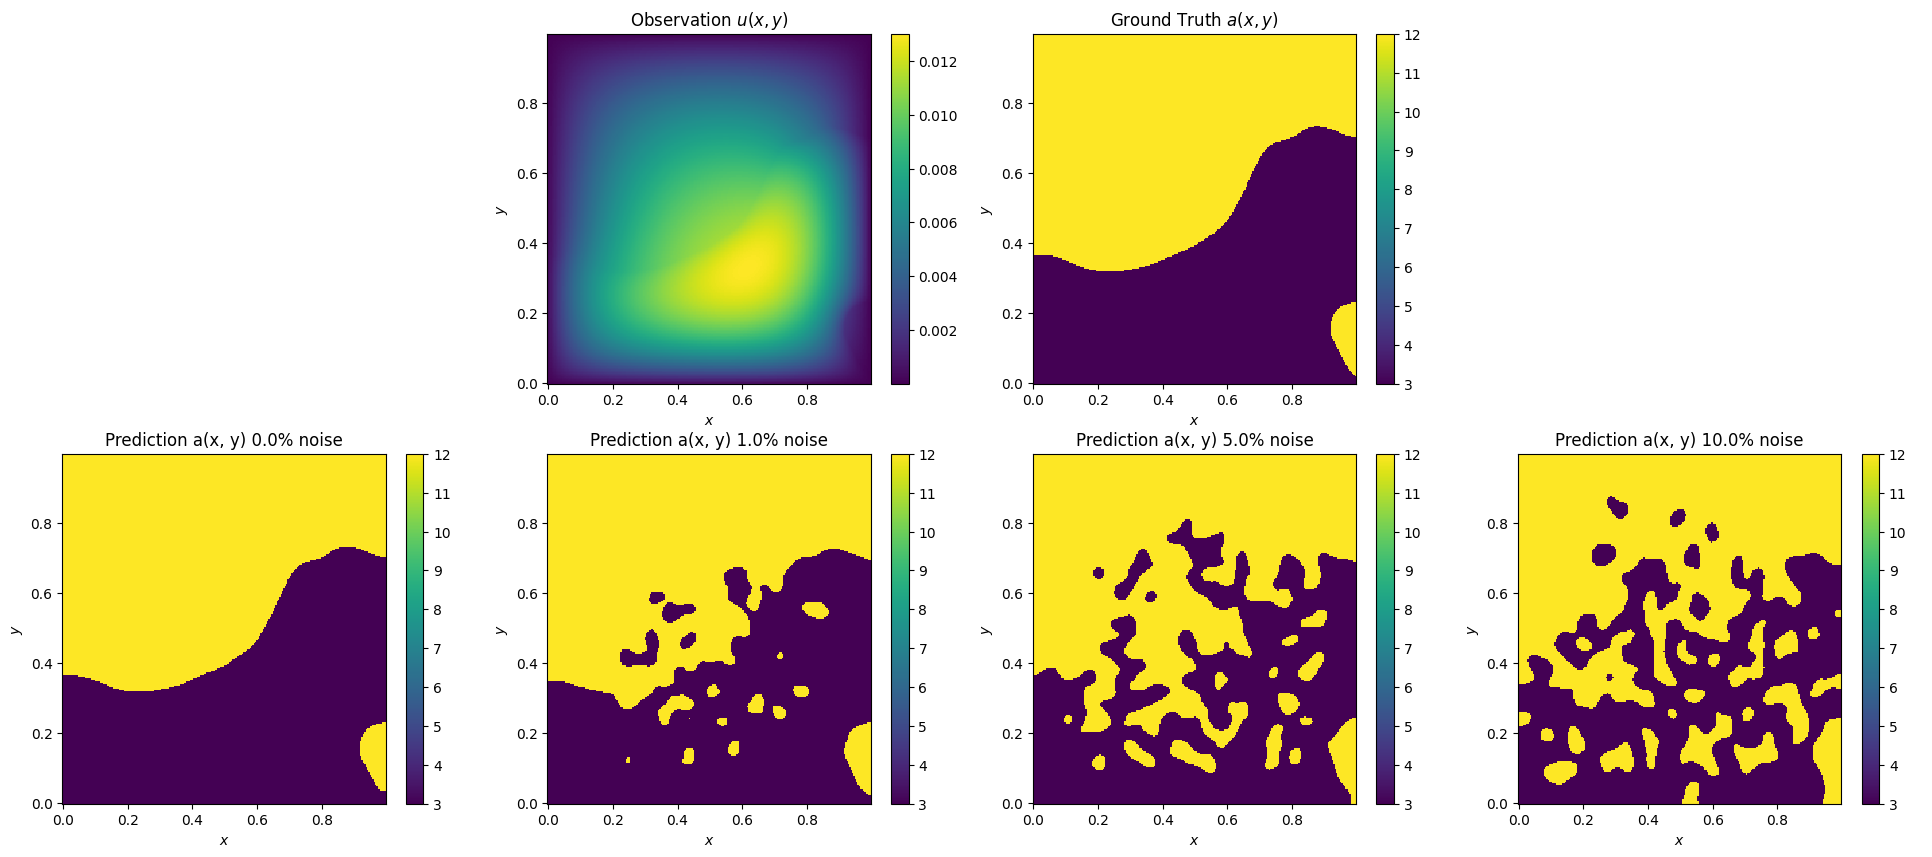

In [22]:
fig, ax = plt.subplots(2, 4, figsize=(24, 10))
ax[0, 0].set_axis_off()
ax[0, 3].set_axis_off()

im1 = ax[0, 1].pcolormesh(X, Y, y)
ax[0, 1].set_xlabel('$x$')
ax[0, 1].set_ylabel('$y$')
ax[0, 1].set_title('Observation $u(x, y)$')
fig.colorbar(im1, ax=ax[0, 1])

im2 = ax[0, 2].pcolormesh(X, Y, unnormalize(x))
ax[0, 2].set_xlabel('$x$')
ax[0, 2].set_ylabel('$y$')
ax[0, 2].set_title('Ground Truth $a(x, y)$')
fig.colorbar(im2, ax=ax[0, 2])

im3 = ax[1, 0].pcolormesh(X, Y, unnormalize(x_pred[0]))
ax[1, 0].set_xlabel('$x$')
ax[1, 0].set_ylabel('$y$')
ax[1, 0].set_title(r'Prediction a(x, y) 0.0% noise')
fig.colorbar(im3, ax=ax[1, 0])

im4 = ax[1, 1].pcolormesh(X, Y, unnormalize(x_pred[1]))
ax[1, 1].set_xlabel('$x$')
ax[1, 1].set_ylabel('$y$')
ax[1, 1].set_title(r'Prediction a(x, y) 1.0% noise')
fig.colorbar(im4, ax=ax[1, 1])

im5 = ax[1, 2].pcolormesh(X, Y, unnormalize(x_pred[2]))
ax[1, 2].set_xlabel('$x$')
ax[1, 2].set_ylabel('$y$')
ax[1, 2].set_title(r'Prediction a(x, y) 5.0% noise')
fig.colorbar(im5, ax=ax[1, 2])

im6 = ax[1, 3].pcolormesh(X, Y, unnormalize(x_pred[3]))
ax[1, 3].set_xlabel('$x$')
ax[1, 3].set_ylabel('$y$')
ax[1, 3].set_title(r'Prediction a(x, y) 10.0% noise')
fig.colorbar(im6, ax=ax[1, 3])

In [23]:
fig.savefig('../assets/darcy/darcy_noise.png', dpi=300, bbox_inches='tight')